# Generate subreddit embeddings
We want some sort of flexible representation for the authors in our data.

Let's try to get an aggregate representation for each author based on the list of subreddits that they previously visited.
Similar to word embeddings, we'll convert these to subreddit embeddings based on coocurrence patterns: 
- matrix factorization
- word2vec

In [5]:
## load data
import os
import pandas as pd
author_dir = '../../data/reddit_data/author_data/'
author_data_files = list(map(lambda x: os.path.join(author_dir, x), os.listdir(author_dir)))
author_data = []
for author_data_file_i in author_data_files:
    try:
        data_i = pd.read_csv(author_data_file_i, sep='\t', compression='gzip', index_col=False)
        author_data.append(data_i)
    except Exception as e:
        print(f'bad file {author_data_file_i}')
#         break
author_data = pd.concat(author_data, axis=0)
print(author_data.shape[0])

bad file ../../data/reddit_data/author_data/OJnToothpaste_comments.gz
bad file ../../data/reddit_data/author_data/Quovef_comments.gz
2636934


In [76]:
display(author_data.head())

,author,subreddit,body,created_utc,edited,id,author_flair_text
0,m4xk0,VALORANT,I think you totally nailed Cypher and Phoenix,1599987688.0,False,g52pbt7,NaN
1,m4xk0,VALORANT,For me this actually doesn't work anymore sinc...,1598598880.0,False,g3422w0,NaN
2,m4xk0,espresso,I dont think stainless vs aluminium would real...,1593333987.0,False,fw90dkn,NaN
3,m4xk0,espresso,Got my shipping confirmation today!,1591876767.0,False,ftor04u,NaN
4,m4xk0,espresso,Thank you,1591194952.0,False,fsr16fe,NaN


In [15]:
## remove bad data
import numpy as np
author_data = author_data[(author_data.loc[:, 'author'].apply(lambda x: type(x) is str)) & 
                          (author_data.loc[:, 'subreddit'].apply(lambda x: type(x) is str))]

How many unique authors per subreddit?

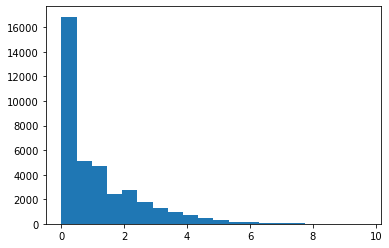

In [16]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
author_unique_subreddit_counts = author_data.groupby('subreddit').apply(lambda x: np.log(x.loc[:, 'author'].nunique()))
plt.hist(author_unique_subreddit_counts, bins=20)
plt.show()

Most subreddits have only 1 unique user, but we still have a decent sample size (>5K) for subreddits with >= 5 authors.

### Matrix factorization
First approach: compute matrix of author-subreddit posting, convert to probabilities, then compress using SVD.

In [43]:
subreddit_author_lists = author_data.groupby('subreddit').apply(lambda x: x.loc[:, 'author'].values)
min_author_count = 100
valid_subreddit_author_lists = subreddit_author_lists[subreddit_author_lists.apply(lambda x: len(x) >= min_author_count)]
valid_subreddits = set(valid_subreddit_author_lists.index)
print(f'{len(valid_subreddit_author_lists)}/{len(subreddit_author_lists)} subreddits with sufficient counts for authors')

3177/37930 subreddits with sufficient counts for authors


Does this still give us decent coverage over authors?

In [44]:
author_subreddit_lists = author_data.groupby('author').apply(lambda x: x.loc[:, 'subreddit'].values)
valid_author_subreddit_lists = author_subreddit_lists[author_subreddit_lists.apply(lambda x: len(set(x) & valid_subreddits) > 0)]
print(f'{len(valid_author_subreddit_lists)}/{len(author_subreddit_lists)} authors with at least one valid subreddit')

28615/28663 authors with at least one valid subreddit


In [45]:
## generate subreddit-author matrix
valid_subreddit_author_str = valid_subreddit_author_lists.apply(lambda x: ' '.join(x))
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df=0., max_df=1., tokenizer=lambda x: x.split(' '))
subreddit_author_dtm = cv.fit_transform(valid_subreddit_author_str)
print(subreddit_author_dtm.shape)

(3177, 28615)


In [46]:
## convert to probabilities
subreddit_author_probs = subreddit_author_dtm / subreddit_author_dtm.sum(axis=1)
print(subreddit_author_probs.shape)

(3177, 28615)


In [47]:
## factorize me Cap'n
from sklearn.decomposition import TruncatedSVD
n_components = 100
svd = TruncatedSVD(n_components=n_components)
subreddit_svd_embeds = svd.fit_transform(subreddit_author_probs)
## add subreddit info
subreddit_svd_embeds = pd.DataFrame(subreddit_svd_embeds, index=valid_subreddit_author_lists.index)
print(subreddit_svd_embeds.shape)
display(subreddit_svd_embeds.head())

(3177, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
subreddit,,,,,,,,,,,,,,,,,,,,,
1200isfineIGUESSugh,-5.452577e-07,2.088829e-07,2.085616e-07,3.118038e-07,3.252644e-07,-2.974917e-07,5.974818e-08,-7.892986e-07,4.927101e-06,3.277223e-06,...,-0.000024,-0.000025,-0.000102,-0.000039,0.000046,0.000007,0.000011,0.000056,0.000020,-0.000007
1200isplenty,-1.426935e-07,2.027698e-07,2.190879e-06,1.560345e-06,1.640374e-06,1.109187e-06,-1.466889e-06,1.676484e-06,4.200482e-06,6.757589e-07,...,0.000010,0.000095,-0.000187,-0.000069,0.000082,-0.000185,-0.000119,0.000001,0.000167,-0.000299
13or30,-1.509998e-06,3.055125e-06,-1.942199e-06,1.302023e-06,-6.367977e-06,2.381944e-07,3.594964e-07,-1.509946e-05,-5.182715e-06,9.801109e-06,...,-0.000846,-0.000396,-0.001457,0.001118,0.000620,0.000993,0.001908,0.000546,0.000034,-0.001016
1500isplenty,-9.640273e-07,8.400015e-07,9.141666e-07,-1.547069e-06,-2.714876e-06,6.084667e-07,-2.880248e-06,-3.998785e-07,1.256640e-06,3.542584e-06,...,0.000195,0.000060,-0.000042,-0.000174,-0.000095,-0.000115,0.000129,-0.000171,-0.000122,-0.000206
196,1.311113e-07,5.068337e-07,-7.630059e-07,2.653959e-07,1.212445e-06,-7.157427e-07,-1.933861e-06,3.577642e-07,-3.720890e-08,-3.499230e-06,...,0.000087,-0.000021,-0.000024,-0.000084,-0.000070,0.000021,0.000023,-0.000057,0.000140,-0.000103


Do we see reasonable "nearest neighbors" for the subreddits?

In [48]:
# print(subreddit_svd_embeds.loc['Advice', :])
from sklearn.metrics.pairwise import cosine_similarity
test_subreddits = ['Advice', 'AmItheAsshole', 'personalfinance', 'legaladvice', 'pcmasterrace']
top_k = 10
for subreddit_i in test_subreddits:
    print(f'**** subreddit={subreddit_i} ****')
    subreddit_sim_i = cosine_similarity(subreddit_svd_embeds.loc[[subreddit_i], :], subreddit_svd_embeds)[0, :]
    subreddit_sim_i = pd.Series(subreddit_sim_i, index=subreddit_svd_embeds.index).sort_values(inplace=False, ascending=False)
    print(subreddit_sim_i.iloc[1:(top_k+1)])

**** subreddit=Advice ****
subreddit
Volkswagen         0.715325
Porsche            0.709080
Golf_R             0.695495
tipofmyjoystick    0.690460
CatsAreAssholes    0.672796
marvelstudios      0.668938
GolfGTI            0.646163
McMansionHell      0.594785
networking         0.570435
homelab            0.559444
dtype: float64
**** subreddit=AmItheAsshole ****
subreddit
RobinHoodPennyStocks    0.632529
Columbus                0.621111
Ohio                    0.614692
justdependathings       0.608713
TeenMomOGandTeenMom2    0.604714
Browns                  0.601842
BBQ                     0.598387
BlueJackets             0.597563
MurderedByWords         0.592304
needadvice              0.571013
dtype: float64
**** subreddit=personalfinance ****
subreddit
WorldOfWarships     0.735031
maryland            0.721411
BreedingMaterial    0.720796
WarshipPorn         0.718353
howardstern         0.714661
minnesotavikings    0.701985
poker               0.692318
DippingTobacco      0.688628
W

Some of these neighbors look decent:
- `pcmasterrace` ~ `GameDeals`
Most of them look overly specific:
- `Advice` ~ `Volkswagen`

Instead of using probabilities, let's try using PMI as the metric for each subreddit-author pair.

In [69]:
subreddit_probs = subreddit_author_dtm.sum(axis=1) / subreddit_author_dtm.sum().sum()
author_probs = subreddit_author_dtm.sum(axis=0) / subreddit_author_dtm.sum().sum()
subreddit_author_probs = subreddit_author_dtm / subreddit_author_dtm.sum().sum()
subreddit_author_joint_probs = subreddit_probs * author_probs
subreddit_author_npmi = -np.log(subreddit_author_probs / subreddit_author_joint_probs)
# fix inf errors
subreddit_author_npmi[np.isinf(subreddit_author_npmi)] = 0

In [73]:
n_components = 100
svd = TruncatedSVD(n_components=n_components)
subreddit_npmi_embeds = svd.fit_transform(subreddit_author_npmi)
## add subreddit info
subreddit_npmi_embeds = pd.DataFrame(subreddit_npmi_embeds, index=valid_subreddit_author_lists.index)
print(subreddit_npmi_embeds.shape)
display(subreddit_npmi_embeds.head())

(3177, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
subreddit,,,,,,,,,,,,,,,,,,,,,
1200isfineIGUESSugh,1.205121,-1.147229,0.955265,0.424174,-1.528973,-0.946653,-1.403166,0.756910,-0.221747,-0.572317,...,-0.822816,-0.453225,0.158153,-0.592284,-0.264219,-0.089661,-0.023626,-0.250020,0.674514,-0.039629
1200isplenty,4.832192,-5.951249,3.253389,2.242349,-4.668701,-3.208919,-4.208803,1.248052,0.103779,-2.067515,...,-2.449297,0.534217,-0.486003,-2.316235,-1.171077,-0.168496,-2.177577,-0.523255,0.303372,0.372297
13or30,5.933591,1.333307,3.905073,-2.849368,0.990872,-0.709703,-0.428899,0.147984,-0.348089,0.298141,...,-0.389256,-0.921148,0.447976,0.766172,-0.336744,-1.980821,0.285599,-0.083067,-0.503754,-0.667090
1500isplenty,1.682105,-1.485067,0.899838,0.480509,-1.178018,-0.859904,-1.086687,0.531295,0.074114,-0.096030,...,-0.735353,-0.075142,-0.953684,-0.403412,-0.531001,0.137837,0.085817,0.160297,0.002467,0.600610
196,3.186235,3.877340,1.641876,-0.766720,-0.675611,3.024258,-1.217627,2.635424,1.847366,-0.061296,...,-0.366855,0.699104,-0.700001,1.263916,-0.761661,0.137847,-0.306674,-0.849755,-0.661184,-0.658028


In [75]:
## test nearest neighbors
test_subreddits = ['Advice', 'AmItheAsshole', 'personalfinance', 'legaladvice', 'pcmasterrace']
top_k = 10
for subreddit_i in test_subreddits:
    print(f'**** subreddit={subreddit_i} ****')
    subreddit_sim_i = cosine_similarity(subreddit_npmi_embeds.loc[[subreddit_i], :], subreddit_npmi_embeds)[0, :]
    subreddit_sim_i = pd.Series(subreddit_sim_i, index=subreddit_npmi_embeds.index).sort_values(inplace=False, ascending=False)
    print(subreddit_sim_i.iloc[1:(top_k+1)])

**** subreddit=Advice ****
subreddit
Crushes            0.508069
questions          0.456777
ask                0.440178
depression_help    0.437396
help               0.407496
LongDistance       0.403750
FreeKarma4You      0.397770
mentalhealth       0.386592
Vent               0.385725
Needafriend        0.383394
dtype: float64
**** subreddit=AmItheAsshole ****
subreddit
AmItheButtface       0.630355
AmITheDevil          0.584822
UCDavis              0.536262
SarahBowmar          0.504433
riverdale            0.490253
greysanatomy         0.459068
glee                 0.450126
childfree            0.433288
HPHogwartsMystery    0.427751
massage              0.423105
dtype: float64
**** subreddit=personalfinance ****
subreddit
churning                 0.786400
CreditCards              0.781209
ynab                     0.744740
awardtravel              0.728706
tax                      0.705419
StudentLoans             0.673530
retirement               0.663772
financialindependence    

Much better! We see actually relevant subreddits in all of the to-K neighbors.

Let's use these representations to compute "reader" representations: we'll take the mean subreddit embedding for each author, over all prior posts.

### Generate embeddings for different time periods
It would be "cheating" to generate one set of embeddings over the whole dataset: if we learn subreddit embeddings from 2018-2019 and then provide those embeddings to an author in 2018, then we're allowing future information to bias the embeddings away from the past.

Let's try to generate embeddings in "chunks" that we can provide to future authors.

In [87]:
## split data by time
from datetime import datetime
import numpy as np
import re
num_matcher = re.compile('\d+\.\d+')
clean_date_author_data = author_data[author_data.loc[:, 'created_utc'].apply(lambda x: num_matcher.match(str(x)) is not None)]
clean_date_author_data = clean_date_author_data.assign(**{
    'date' : clean_date_author_data.loc[:, 'created_utc'].apply(lambda x: datetime.fromtimestamp(int(float(x))))
})
clean_date_author_data = clean_date_author_data.assign(**{
    'date_day' : clean_date_author_data.loc[:, 'date'].apply(lambda x: datetime(year=x.year, month=x.month, day=x.day))
})

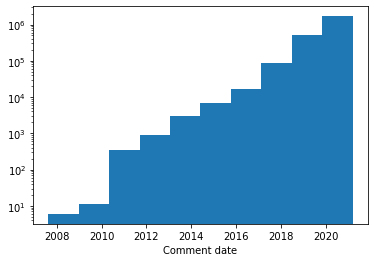

In [90]:
plt.hist(clean_date_author_data.loc[:, 'date_day'])
plt.yscale('log')
plt.xlabel('Comment date')
plt.show()

We originally collected comments from 2018-2019, so this skew in the data is to be expected!

Let's specify the following time periods to use for learning embeddings:
- 2008-2018
- 2018/01-2018/06
- 2018/07-2018/12
- 2019/01-2019/06

It's not ideal but it should capture enough diversity in the data to provide robust subreddit embeddings.

In [104]:
author_time_periods = [
    (2018, 1, 1),
    (2018, 7, 1),
    (2019, 1, 1),
    (2019, 7, 1),
]
author_time_periods = list(map(lambda x: datetime(year=x[0], month=x[1], day=x[2]).timestamp(), author_time_periods))
clean_date_author_data = clean_date_author_data.assign(**{
    'date_day_bin' : np.digitize(clean_date_author_data.loc[:, 'date_day'].apply(lambda x: x.timestamp()), bins=author_time_periods)
})
date_fmt = '%Y-%m-%d'
clean_date_author_data = clean_date_author_data.assign(**{
    'date_day_bin' : clean_date_author_data.loc[:, 'date_day_bin'].apply(lambda x: datetime.strftime(datetime.fromtimestamp(author_time_periods[x]), date_fmt) if x < len(author_time_periods) else -1)
})
print(clean_date_author_data.loc[:, 'date_day_bin'].value_counts())

-1            1886504
2019-07-01     204784
2019-01-01     121107
2018-07-01      61007
2018-01-01      56983
Name: date_day_bin, dtype: int64


In [105]:
valid_date_bin_author_data = clean_date_author_data[clean_date_author_data.loc[:, 'date_day_bin']!=-1]

In [107]:
## quick and dirty embedding code lol
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
def generate_embeddings(data, min_author_count=20):
    ## remove low-count subreddits
    subreddit_counts = data.groupby('subreddit').apply(lambda x: x.loc[:, 'author'].nunique())
    high_freq_subreddits = set(subreddit_counts[subreddit_counts >= min_author_count].index.tolist())
    data = data[data.loc[:, 'subreddit'].isin(high_freq_subreddits)]
    ## generate subreddit-author matrix
    subreddit_author_lists = data.groupby('subreddit').apply(lambda x: x.loc[:, 'author'].values)
    min_author_count = 100
    valid_subreddit_author_lists = subreddit_author_lists[subreddit_author_lists.apply(lambda x: len(x) >= min_author_count)]
    valid_subreddit_author_str = valid_subreddit_author_lists.apply(lambda x: ' '.join(x))
    cv = CountVectorizer(min_df=0., max_df=1., tokenizer=lambda x: x.split(' '))
    subreddit_author_dtm = cv.fit_transform(valid_subreddit_author_str)
    ## compute NPMI
    subreddit_probs = subreddit_author_dtm.sum(axis=1) / subreddit_author_dtm.sum().sum()
    author_probs = subreddit_author_dtm.sum(axis=0) / subreddit_author_dtm.sum().sum()
    subreddit_author_probs = subreddit_author_dtm / subreddit_author_dtm.sum().sum()
    subreddit_author_joint_probs = subreddit_probs * author_probs
    subreddit_author_npmi = -np.log(subreddit_author_probs / subreddit_author_joint_probs)
    # fix inf errors
    subreddit_author_npmi[np.isinf(subreddit_author_npmi)] = 0
    # SVD
    n_components = 100
    svd = TruncatedSVD(n_components=n_components)
    subreddit_npmi_embeds = svd.fit_transform(subreddit_author_npmi)
    ## add subreddit info
    subreddit_npmi_embeds = pd.DataFrame(subreddit_npmi_embeds, index=valid_subreddit_author_lists.index)
    return subreddit_npmi_embeds

In [108]:
## get embeddings for each date bin
date_bin_embeddings = []
for date_i, data_i in clean_date_author_data.groupby('date_day_bin'):
    embeds_i = generate_embeddings(data_i)
    date_bin_embeddings.append([date_i, embeds_i])

<ipython-input-107-bbf6b2bbb6fa>:21: RuntimeWarning: divide by zero encountered in log
  subreddit_author_npmi = -np.log(subreddit_author_probs / subreddit_author_joint_probs)
<ipython-input-107-bbf6b2bbb6fa>:21: RuntimeWarning: divide by zero encountered in log
  subreddit_author_npmi = -np.log(subreddit_author_probs / subreddit_author_joint_probs)
<ipython-input-107-bbf6b2bbb6fa>:21: RuntimeWarning: divide by zero encountered in log
  subreddit_author_npmi = -np.log(subreddit_author_probs / subreddit_author_joint_probs)
<ipython-input-107-bbf6b2bbb6fa>:21: RuntimeWarning: divide by zero encountered in log
  subreddit_author_npmi = -np.log(subreddit_author_probs / subreddit_author_joint_probs)
<ipython-input-107-bbf6b2bbb6fa>:21: RuntimeWarning: divide by zero encountered in log
  subreddit_author_npmi = -np.log(subreddit_author_probs / subreddit_author_joint_probs)
